# The Unscented Kalman Filter

In [3]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

在上一章中，我们讨论了非线性系统带来的困难。 这种非线性可能出现在两个地方。 它可以在我们的测量中，例如测量物体斜距的雷达。 倾斜范围要求您取平方根来计算 x,y 坐标：

$$x=\sqrt{\text{slant}^2 - \text{altitude}^2}$$

非线性也可能出现在过程模型中——我们可能正在跟踪一个在空气中运动的球，其中空气阻力的影响导致非线性行为。 标准卡尔曼滤波器在处理这些类型的问题时表现不佳或根本没有表现。

在上一章中，我向您展示了这样的情节。 我稍微改变了方程以强调非线性的影响。

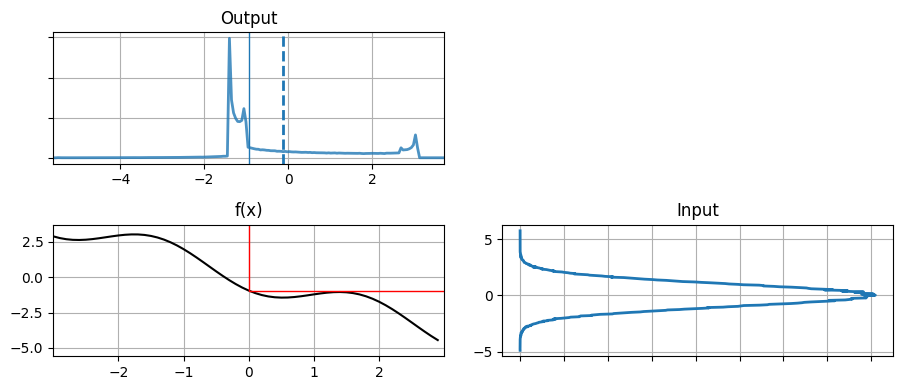

In [3]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np

# create 500,000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

plot_nonlinear_func(data, f)

我通过从输入中获取 500,000 个样本，将其传递给非线性变换并构建结果的直方图来生成它。 我们称这些点为*sigma points*。 从输出直方图，我们可以计算均值和标准差，这将为我们提供更新的，尽管是近似的高斯分布。

让我向您展示数据通过 f(x) 之前和之后的散点图。

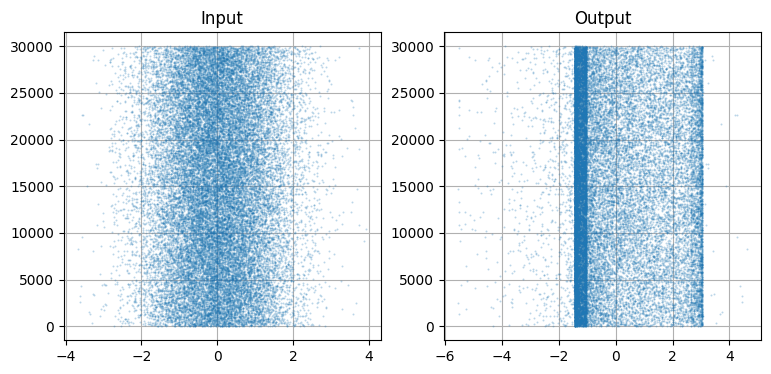

In [4]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1);

数据本身似乎是高斯的，确实如此。 我的意思是它看起来像分散在均值零周围的白噪声。 相比之下，`g(data)` 有一个定义好的结构。 有两个波段，中间有很多点。 在带的外侧有分散的点，但在负面方面还有更多。

您可能已经想到，这个采样过程构成了我们问题的解决方案。 假设每次更新我们生成 500000 个点，将它们传递给函数，然后计算结果的均值和方差。 这称为 *Monte Carlo* 方法，它被一些卡尔曼滤波器设计使用，例如集成滤波器和粒子滤波器。 采样不需要专业知识，也不需要封闭形式的解决方案。 无论函数多么非线性或表现多么糟糕，只要我们用足够多的 sigma 点进行采样，我们就会建立一个准确的输出分布。

“足够的点数”是关键。 上图是用 500000 个 sigma 点创建的，输出仍然不平滑。 更糟糕的是，这仅适用于 1 维。 所需的点数随维数的幂而增加。 如果一个维度只需要 500 个点，那么你需要 500 个平方，或 250,000 个点的二维，500 个立方，或 125,000,000 个点的三维，等等。 因此，虽然这种方法确实有效，但它的计算成本非常高。 集成过滤器和粒子过滤器使用巧妙的技术来显着降低这种维度，但计算负担仍然非常大。 无迹卡尔曼滤波器使用西格玛点，但通过使用确定性方法来选择点，大大减少了计算量。

## Sigma Points - Sampling from a Distribution

让我们从 2D 协方差椭圆的角度来看问题。 我选择 2D 只是因为它易于绘制； 这扩展到任意数量的维度。 假设有一些任意的非线性函数，我们将从第一个协方差椭圆中随机抽取点，将它们通过非线性函数，并绘制它们的新位置。 然后我们可以计算变换点的均值和协方差，并将其用作我们对均值和概率分布的估计。

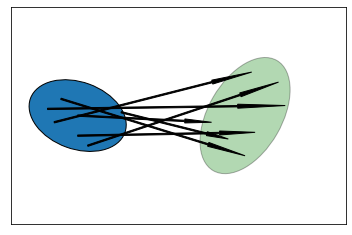

In [4]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

在左边，我们展示了一个椭圆，描绘了两个状态变量的 $1\sigma$ 分布。 箭头显示了一些随机采样点如何被一些任意非线性函数转换为新的分布。 右边的椭圆是半透明的，表示它是这个点集合的均值和方差的*估计*。

让我们编写一个函数，它通过从高斯随机抽取的 10,000 个点

$$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

通过非线性系统：

$$\begin{cases}\begin{aligned}\bar x&=x+y\\
\bar y&= 0.1x^2 + y^2\end{aligned} \end{cases}$$ 


Difference in mean x=0.172, y=42.522


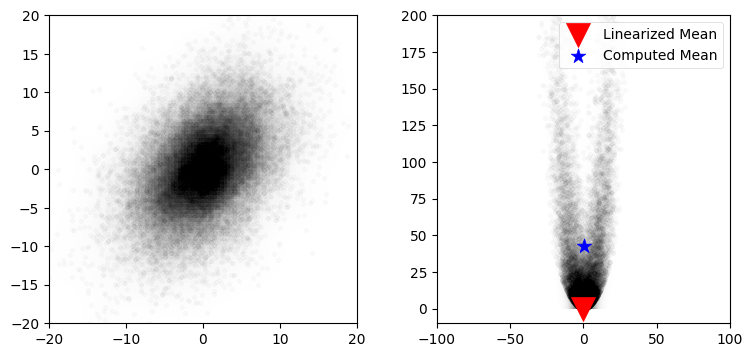

In [6]:
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean');

该图显示了此函数发生的强非线性，以及如果我们以扩展卡尔曼滤波器的方式线性化将导致的大误差（我们将在下一章中学习）。

## A Quick Example

我很快将进入无迹卡尔曼滤波器 (UKF) 用于选择 sigma 点然后执行计算的数学。 但让我们从一个例子开始，这样你就可以看到目的地，可以这么说。

我们将了解到 UKF 可以使用许多不同的算法来生成 sigma 点。 FilterPy 提供了几种算法。 这是一种可能性：

In [7]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

这稍后会变得更清楚，但对象将为任何给定的均值和协方差生成加权 sigma 点。 让我们看一个例子，其中点的大小表示它的权重：

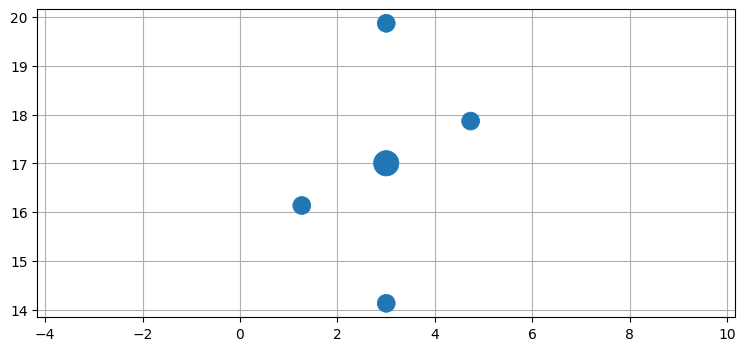

In [8]:
from kf_book.ukf_internal import plot_sigmas
plot_sigmas(sigmas, x=[3, 17], cov=[[1, .5], [.5, 3]])

你可以看到我们有 5 个点，以奇数模式围绕均值 (3, 17)。 与 500,000 个随机生成的点一样好或更好，这似乎很荒谬，但它会！

好的，现在让我们实现过滤器。 我们将在一维中实现一个标准的线性滤波器； 我们还没有准备好处理非线性滤波器。 过滤器的设计与我们目前所学的没有太大区别，只有一个区别。 KalmanFilter 类使用矩阵 $\mathbf F$ 来计算状态转换函数。 矩阵意味着**线性**代数，它适用于线性问题，但不适用于非线性问题。 因此，我们提供了一个函数，而不是矩阵，就像我们上面所做的那样。 KalmanFilter 类使用另一个矩阵 $\mathbf H$ 来实现测量功能，将状态转换为等效测量。 同样，矩阵意味着线性，所以我们提供一个函数来代替矩阵。 也许很清楚为什么 $\mathbf H$ 被称为“测量函数”； 对于线性卡尔曼滤波器，它是一个矩阵，但这只是计算恰好是线性的函数的一种快速方法。

不用多说，这里是一维跟踪问题的状态转换函数和测量函数，其中状态为 $\mathbf x = [x \, \, \dot x]^ \mathsf T$：

In [9]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

让我们明确一点，这是一个线性示例。 没有必要对线性问题使用 UKF，但我从最简单的例子开始。 但是请注意我如何编写 `fx()` 来计算 $\mathbf{\bar x}$ 作为一组方程而不是矩阵乘法。 这是为了说明我可以在这里实现任意的非线性函数； 我们不受限于线性方程。

其余的设计是相同的。 设计 $\mathbf P$、$\mathbf R$ 和 $\mathbf Q$。 你知道怎么做，所以让我们完成过滤器并运行它。

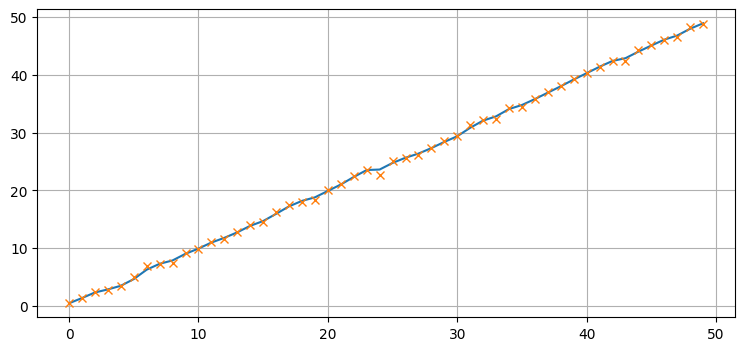

In [10]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs);
plt.plot(zs, marker='x', ls='');

这里真的没有很多新东西。 你必须创建一个为你创建 sigma 点的对象，并为 𝐅 和 𝐇 提供函数而不是矩阵，但其余的和以前一样。 这应该给你足够的信心来研究一些数学和算法，这样你就可以了解 UKF 在做什么

## Choosing Sigma Points

在本章的开头，我使用了 500,000 个随机生成的 sigma 点来计算高斯通过非线性函数的概率分布。 虽然计算的平均值非常准确，但每次更新计算 500,000 个点会导致我们的过滤器非常慢。 那么，我们可以使用的最少采样点数是多少，这个问题公式对点施加了什么样的约束？ 我们将假设我们没有关于非线性函数的特殊知识，因为我们想找到适用于任何函数的广义算法。

让我们考虑最简单的情况，看看它是否提供了任何见解。 最简单的系统是**恒等函数**：$f(x) = x$。 如果我们的算法不适用于恒等函数，则过滤器无法收敛。 换句话说，如果输入为 1（对于一维系统），则输出也必须为 1。如果输出不同，例如 1.1，那么当我们在下一时间步将 1.1 送入变换时，我们' d 得出另一个数字，也许是 1.23。 此过滤器发散。

我们可以使用的最少点数是每个维度一个。 这是线性卡尔曼滤波器使用的数字。 分布 $\mathcal{N}(\mu,\sigma^2)$ 的卡尔曼滤波器的输入是 $\mu$ 本身。 因此，虽然这适用于线性情况，但对于非线性情况却不是一个好的答案。

也许我们可以在每个维度上使用一个点，但以某种方式进行了更改。 然而，如果我们将某个值 $\mu+\Delta$ 传递给恒等函数 $f(x)=x$ 它不会收敛，所以这将不起作用。 如果我们不改变 $\mu$ 那么这将是标准的卡尔曼滤波器。 我们必须得出结论，一个样本是行不通的。

我们可以选择的下一个最低数字是多少？ 二。 考虑这样一个事实，即高斯分布是对称的，而且我们可能希望始终让我们的样本点之一是输入的均值，以使恒等函数起作用。 两个点需要我们选择平均值，然后再选择一个点。 另一点会在我们的输入中引入我们可能不想要的不对称。 对于恒等函数 $f(x)=x$ 进行这项工作将是非常困难的。

次低的数字是 3 分。 3 个点允许我们选择平均值，然后在平均值的每一侧选择一个点，如下图所示。

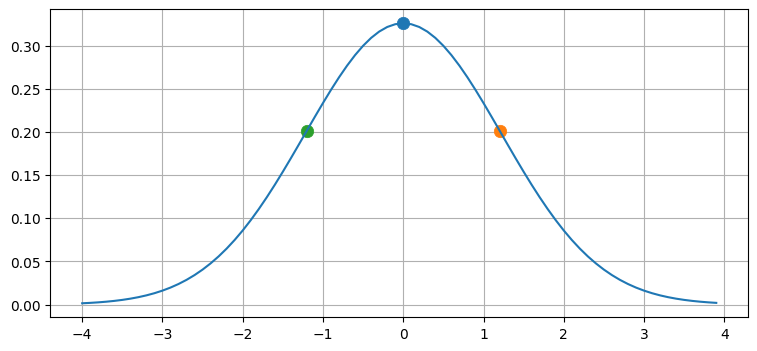

In [11]:
ukf_internal.show_3_sigma_points()

我们可以通过非线性函数 f(x) 传递这些点并计算结果的均值和方差。 平均值可以计算为 3 个点的平均值，但这不是很普遍。 例如，对于一个非常非线性的问题，我们可能希望中心点的权重比外部点高得多，或者我们可能希望外部点的权重更高。

更通用的方法是计算加权平均值 $\mu = \sum_i w_i\, f(\mathcal{X}_i)$，其中书法 $\mathcal{X}$ 是 sigma 点。 我们需要权重之和等于 1。 鉴于该要求，我们的任务是选择 $\mathcal{X}$ 及其相应的权重，以便它们计算转换后的 sigma 点的均值和方差。

如果我们对均值进行加权，那么对协方差进行加权也是有意义的。 可以对均值 ($w^m$) 和协方差 ($w^c$) 使用不同的权重。 我使用上标为以下等式中的索引留出空间。 我们可以写

$$\begin{aligned}
\mathbf{Constraints:}\\
1 &= \sum_i{w_i^m} \\
1 &= \sum_i{w_i^c} \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

前两个方程是权重总和必须为 1 的约束。 第三个等式是如何计算权重平均值。 第四个方程可能不太熟悉，但请记住，两个随机变量的协方差方程是：

$$COV(x,y) = \frac{\sum(x-\bar x)(y-\bar{y})}{n}$$

这些约束不会形成唯一的解决方案。 例如，如果您将 $w^m_0$ 变小，您可以通过将 $w^m_1$ 和 $w^m_2$ 变大来进行补偿。 您可以对均值和协方差使用不同的权重，也可以使用相同的权重。 事实上，这些方程根本不需要任何点是输入的平均值，尽管这样做似乎“很好”，可以这么说。

我们想要一个满足约束的算法，最好每个维度只有 3 个点。 在我们继续之前，我想确保这个想法是明确的。 以下是具有不同 sigma 点的相同协方差椭圆的三个不同示例。 西格玛点的大小与赋予每个点的权重成正比。

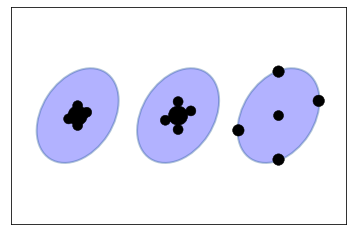

In [6]:
ukf_internal.show_sigma_selections()

这些点不位于椭圆的长轴和短轴上； 约束中的任何内容都不需要我这样做。 我显示了均匀分布的点，但约束不需要这样做。

sigma 点的排列和权重会影响我们对分布进行采样的方式。 靠近的点将采样局部效应，因此可能更适合非常非线性的问题。 相距较远或远离椭圆轴的点将采样非局部效应和非高斯行为。 但是，通过改变用于每个点的权重，我们可以减轻这种情况。 如果这些点远离均值但权重很小，我们将结合一些关于分布的知识，而不允许问题的非线性造成错误的估计。

请理解选择 sigma 点的方法有无数种。 我选择的约束只是一种方法。 例如，并非所有用于创建 sigma 点的算法都要求权重之和为 1。 事实上，我在这本书中喜欢的算法没有这个特性。

## The Unscented Transform

目前，假设存在用于选择 sigma 点和权重的算法。 sigma 点如何用于实现过滤器？

*无味变换*是算法的核心，但它非常简单。 它通过非线性函数传递 sigma 点 $\boldsymbol{\chi}$，产生一组变换的点。

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

然后计算变换点的均值和协方差。 该均值和协方差成为新的估计值。 下图描述了无迹变换的操作。 右侧的绿色椭圆表示计算的均值和变换后的 sigma 点的协方差。


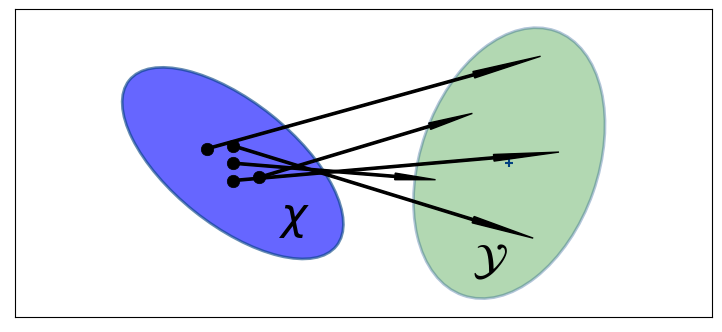

In [12]:
ukf_internal.show_sigma_transform(with_text=True)

sigma 点的均值和协方差计算如下：

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

这些方程应该很熟悉——它们是我们上面开发的约束方程。

简而言之，无迹变换从某个任意概率分布中采样点，将它们传递给任意的非线性函数，并为每个变换点生成高斯分布。 我希望您能想象我们如何使用它来实现非线性卡尔曼滤波器。 一旦我们有了高斯函数，我们已经开发的所有数学仪器就可以发挥作用了！

“无味”这个名字可能会让人困惑。 其实意义不大。 发明者开的一个玩笑说他的算法没有“臭”，很快这个名字就被卡住了。 该术语没有数学意义。

### Accuracy of the Unscented Transform

早些时候，我们编写了一个函数，该函数通过将 50,000 个点传递给非线性函数来找到分布的均值。 现在让我们通过相同的函数传递 5 个 sigma 点，并使用无迹变换计算它们的平均值。 我们将使用 FilterPy 函数 *MerweScaledSigmaPoints()* 创建 sigma 点并使用 `unscented_transform` 来执行变换； 稍后我们将了解这些功能。 在本章的第一个例子中，我使用了 `JulierSigmaPoints`； 他们都选择 sigma 点，但方式不同，我将在后面解释。

Difference in mean x=-0.097, y=0.549


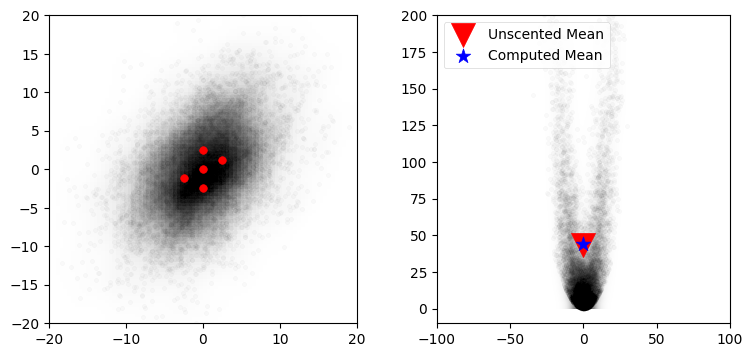

In [13]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

#generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30);

我觉得这个结果很了不起。 仅使用 5 个点，我们就能够以惊人的准确度计算平均值。 x 中的误差仅为 -0.097，y 中的误差为 0.549。 相比之下，线性化方法（由 EKF 使用，我们将在下一章学习）在 y 中的误差超过 43。 如果您查看生成 sigma 点的代码，您会发现它不了解非线性函数，只了解初始分布的均值和协方差。 如果我们有一个完全不同的非线性函数，将生成相同的 5 sigma 点。

我承认选择了一个非线性函数，与 EKF 相比，它使无味变换的性能引人注目。 但是物理世界充满了非常非线性的行为，而 UKF 则从容应对。 我没有“努力”找到无味变换碰巧运行良好的功能。 您将在下一章看到更传统的技术如何与强非线性作斗争。 这张图是我建议您尽可能使用 UKF 或类似现代技术的基础。

## The Unscented Kalman Filter

我们现在可以展示 UKF 算法。

### Predict Step

UKF 的预测步骤使用过程模型 $f()$ 计算先验。 假设 $f()$ 是非线性的，所以我们生成 sigma 点 $\mathcal{X}$ 和它们对应的权重 $W^m, W^c$
根据一些功能：

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

我们通过 $f(\mathbf x, \Delta t)$ 传递每个 sigma 点。 这根据过程模型将 sigma 点在时间上向前投影，形成新的先验，这是我们命名的一组 sigma 点
$\boldsymbol{\mathcal Y}$:

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

我们在转换后的 sigma 点上使用 *unscented 变换 * 计算先验的均值和协方差。

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

这些是无味变换的方程

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

此表将线性卡尔曼滤波器与无迹卡尔曼滤波器方程进行比较。 为了便于阅读，我去掉了下标 $i$。

$$\begin{array}{l|l}
\text{Kalman} & \text{Unscented} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$

### Update Step

卡尔曼滤波器在测量空间中执行更新。 因此，我们必须使用您定义的测量函数 $h(x)$ 将先验的 sigma 点转换为测量值。

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

我们使用无味变换计算这些点的均值和协方差。 $z$ 下标表示这些是测量sigma 点的均值和协方差。

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

接下来我们计算残差和卡尔曼增益。 测量值 $\mathbf z$ 的残差计算起来很简单：

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

为了计算卡尔曼增益，我们首先计算状态和测量值的 [交叉协方差](https://en.wikipedia.org/wiki/Cross-covariance)，其定义为：

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

然后卡尔曼增益定义为

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

如果您将逆视为*某种*矩阵倒数，您可以看到卡尔曼增益是一个简单的比率，它计算：

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{belief in state}}{\text{belief in measurement}}$$

最后，我们使用残差和卡尔曼增益计算新的状态估计：

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

并且新的协方差计算为

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

这一步包含一些你必须相信的方程，但你应该能够看到它们与线性卡尔曼滤波器方程的关系。 线性代数与线性卡尔曼滤波器略有不同，但算法与我们在整本书中一直在实现的贝叶斯算法相同。

该表比较了线性 KF 和 UKF 方程的方程。

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$


## Van der Merwe's Scaled Sigma Point Algorithm

有许多用于选择 sigma 点的算法。 自 2005 年左右以来，研究和工业界大多采用 Rudolph Van der Merwe 在 2004 年的博士论文中发表的版本 [1]。 它在处理各种问题时表现良好，并且在性能和准确性之间取得了良好的平衡。 它是对 Simon J. Julier [2] 发布的 *Scaled Unscented Transform* 的轻微重新表述。

此公式使用 3 个参数来控制 sigma 点的分布和加权方式：$\alpha$、$\beta$ 和 $\kappa$。 在我们研究方程式之前，让我们看一个例子。 我将在显示第一和第二标准差的协方差椭圆顶部绘制 sigma 点，并根据平均权重缩放这些点。

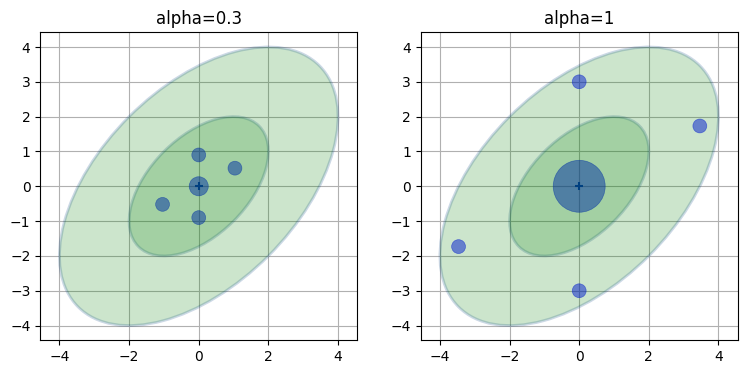

In [14]:
ukf_internal.plot_sigma_points()

我们可以看到 sigma 点位于第一个和第二个标准偏差之间，并且较大的 $\alpha$ 将这些点分散开。 此外，较大的 $\alpha$ 对平均值（中心点）的权重高于较小的 $\alpha$，其余部分的权重较小。 这应该符合我们的直觉——点离平均值越远，我们应该对其加权越小。 我们还不知道这些权重和 sigma 点是如何选择的，但这些选择看起来很合理。

### Sigma Point Computation

第一个 sigma 点是输入的平均值。 这是上图中椭圆中心显示的 sigma 点。 我们称之为 $\boldsymbol{\chi}_0$。

$$ \mathcal{X}_0 = \mu$$

为了符号方便，我们定义 $\lambda = \alpha^2(n+\kappa)-n$，其中 $n$ 是 $\mathbf x$ 的维度。 剩余的sigma points计算为

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& \text{for i=1 .. n} \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &\text{for i=(n+1) .. 2n}\end{cases}
$$

$i$ 下标选择矩阵的 i$^{th}$ roth 向量。

换句话说，我们用一个常数缩放协方差矩阵，取它的平方根，并通过从平均值中添加和减去它来确保对称性。 稍后我们将讨论如何取矩阵的平方根。

### Weight Computation

该公式使用一组权重作为均值，使用另一组权重作为协方差。 $\mathcal{X}_0$ 均值的权重计算如下

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

$\mathcal{X}_0$ 协方差的权重是

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

其余 sigma 点的权重 $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ 对于均值和协方差是相同的。 他们是

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

可能不清楚为什么这是“正确的”，实际上，无法证明这对所有非线性问题都是理想的。 但是可以看到我们选择的sigma点与协方差矩阵的平方根成正比，方差的平方根就是标准差。 因此，sigma 点大致根据 $\pm 1\sigma$ 乘以某个比例因子进行分布。 分母中有一个 $n$ 项，因此维度越多，点的分布和权重就越小。

**重要说明：** 通常这些权重之和不会为 1。 我对此有很多疑问。 获得总和大于 1 的权重，甚至是负值是预期的。 我在下面更详细地介绍了这一点。

### Reasonable Choices for the Parameters

$\beta=2$ 是高斯问题的好选择， $\kappa=3-n$ 其中 $n$ 是 $\mathbf 的维度 x$ 是 $\kappa$ 的好选择，而 $0 \le \ alpha \le 1$ 是 $\alpha$ 的合适选择，其中 $\alpha$ 的较大值会使 sigma 点远离均值。

## Using the UKF

让我们解决一些问题，以便您对 UKF 的易用性充满信心。 我们将从一个您已经知道如何使用线性卡尔曼滤波器解决的线性问题开始。 虽然 UKF 是为非线性问题设计的，但它找到了与线性卡尔曼滤波器对线性问题相同的最优结果。 我们将编写一个过滤器来使用恒定速度模型在 2D 中跟踪对象。 这将使我们能够专注于与 UKF 相同的地方（并且大多数相同！）以及不同的地方。

设计卡尔曼滤波器需要您指定 $\bf{x}$、$\bf{F}$、$\bf{H}$、$\bf{R}$ 和 $\bf{Q}$ 矩阵 . 我们已经这样做了很多次，所以我会在没有太多讨论的情况下给你矩阵。 我们想要一个恒速模型，所以我们定义 $\bf{x}$ 为


$$ \mathbf x = \begin{bmatrix}x &  \dot x & y & \dot y \end{bmatrix}^\mathsf{T}$$

通过这种状态变量的排序，状态转移矩阵是

$$\mathbf F = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

实现牛顿方程

$$\begin{aligned}
x_k &= x_{k-1} + \dot x_{k-1}\Delta t \\
y_k &= y_{k-1} + \dot y_{k-1}\Delta t
\end{aligned}$$

我们的传感器提供位置而不是速度，因此测量功能是

$$\mathbf H = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

传感器读数以米为单位，*x* 和 *y* 中的误差为 $\sigma=0.3$ 米。 这给了我们一个测量噪声矩阵

$$\mathbf R = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

最后，让我们假设过程噪声可以用离散白噪声模型表示——也就是说，在每个时间段内，加速度都是恒定的。 我们可以使用 `FilterPy` 的 `Q_discrete_white_noise()` 来为我们创建这个矩阵，但为了回顾一下，矩阵是

$$\mathbf Q = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

我对这个过滤器的实现是：

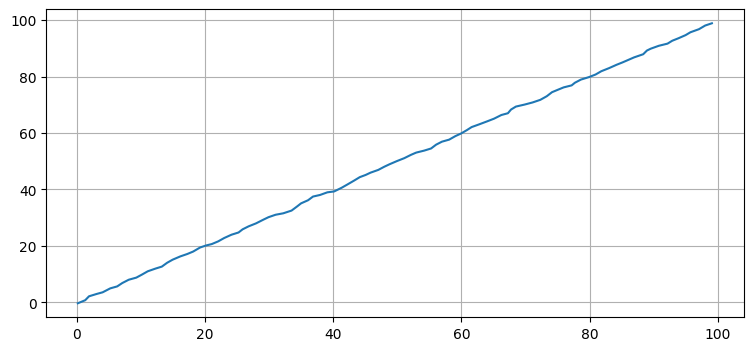

In [15]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y = .3, .3
dt = 1.0

np.random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([std_x**2, std_y**2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2]);

这应该不会让您感到意外。 现在让我们实现一个 UKF。 同样，这纯粹是出于教育目的； 使用 UKF 解决线性问题没有任何好处。 `FilterPy` 使用类 `UnscentedKalmanFilter` 实现了 UKF。

首先要做的是实现函数 f(x, dt) 和 h(x) 。 `f(x, dt)` 实现了状态转换函数，`h(x)` 实现了测量函数。 这些对应于线性滤波器中的矩阵 $\mathbf F$ 和 $\mathbf H$。

下面是这两个函数的合理实现。 每个都应该返回一个包含结果的一维 NumPy 数组或列表。 你可以给它们起比 `f` 和 `h` 更易读的名字。



In [16]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x):
    return x[[0, 2]]

接下来，您指定如何计算 sigma 点和权重。 我们在上面给出了 Van der Merwe 的版本，但是有很多不同的选择。 FilterPy 使用一个名为 SigmaPoints 的类，它必须实现一个方法：

```python
def sigma_points(self, x, P)
```

并包含属性“Wm”和“Wc”，它们分别持有用于计算均值和协方差的权重。

FilterPy 从 SigmaPoints 派生类 MerweScaledSigmaPoints 并实现上述方法。

创建 UKF 时，您将传入 $f()$ 和 $h()$ 函数以及 sigma 点对象，如下例所示：

```python
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, points=points)
```

其余代码与线性卡尔曼滤波器相同。 我将使用相同的测量值并计算两种解决方案之间差异的标准偏差。

UKF standard deviation 0.013 meters


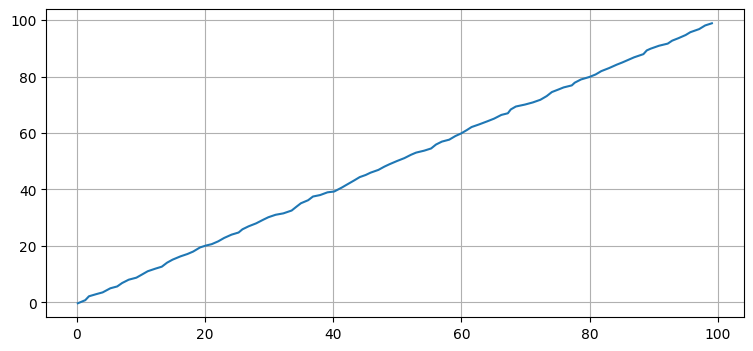

In [17]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')

这给了我一个 0.013 米的标准偏差，这非常小。

UKF 的实现与线性卡尔曼滤波器没有太大区别。 不是将状态转换和测量函数实现为矩阵 $\mathbf F$ 和 $\mathbf H$，而是提供非线性函数 `f()` 和 `h()`。 其余的理论和实现保持不变。 实现 `predict()` 和 `update()` 的代码不同，但从设计者的角度来看，问题制定和过滤器设计非常相似。

## Tracking an Airplane

让我们解决我们的第一个非线性问题。 我们将编写一个过滤器来使用雷达作为传感器来跟踪飞机。 为了使问题尽可能与前一个问题相似，我们将在两个维度上进行跟踪。 我们将跟踪地面上的一维和飞机的高度。 每个维度都是独立的，因此我们可以在不失一般性的情况下做到这一点。

雷达通过发射无线电波或微波来工作。 光束路径中的任何东西都会将一些信号反射回雷达。 通过计时反射信号返回所需的时间，它可以计算到目标的*倾斜距离*。 斜距是雷达到物体的直线距离。 使用天线的*定向增益*计算方位。

我们从倾斜距离和仰角计算飞机的 (x,y) 位置，如下图所示：

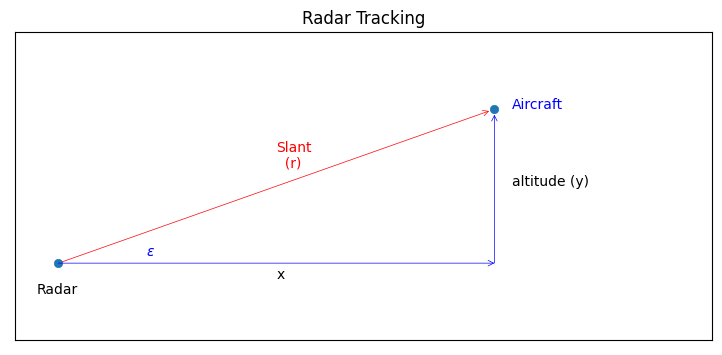

In [18]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_radar_chart()

*仰角* $\epsilon$ 是地面形成的视线上方的角度。

我们将假设飞机在恒定高度飞行。 因此，我们有一个三变量状态向量：

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

状态转移函数是线性的


$$\mathbf{\bar x} = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}
$$

并且可以用以下方法计算：

In [19]:
def f_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

接下来我们设计测量功能。 与线性卡尔曼滤波器一样，测量函数将滤波器的先验值转换为测量值。 我们需要将飞机的位置和速度转换为雷达站的仰角和距离。

范围是用勾股定理计算的：

$$\text{range} = \sqrt{(x_\text{ac} - x_\text{radar})^2 + (y_\text{ac} - y_\mathtt{radar})^2}$$

仰角 $\epsilon$ 是 $y/x$ 的反正切：

$$\epsilon = \tan^{-1}{\frac{y_\mathtt{ac} - y_\text{radar}}{x_\text{ac} - x_\text{radar}}}$$

我们需要定义一个 Python 函数来计算它。 我将利用一个函数可以拥有一个变量来存储雷达位置的事实。 虽然这对于这个问题不是必需的（我们可以对值进行硬编码，或使用全局），但这为函数提供了更大的灵活性。

In [20]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

有一个我们没有考虑的非线性，即角度是模数的事实。 残差是测量与投影到测量空间的先验之间的差异。 359° 和 1° 之间的角度差为 2°，但 359° - 1° = 358°。 计算无味变换中加权值总和的 UKF 加剧了这种情况。 现在，我们将把传感器和目标放置在避开这些非线性区域的位置。 稍后我会告诉你如何处理这个问题。

我们需要模拟雷达和飞机。 到目前为止，这对你来说应该是第二天性，所以我提供代码而不讨论。

In [21]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

军用级雷达可实现 1 米 RMS 范围精度和 1 mrad RMS 仰角 [1]。 我们将假设更适中的 5 米范围精度和 0.5° 角精度，因为这为滤波器提供了更具挑战性的数据集。

$\mathbf Q$ 的设计需要一些讨论。 状态是 $\begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$。 前两个元素是距离和速度，因此我们可以使用“Q_discrete_white_noise”噪声来计算 Q 左上角的值。第三个元素是高度，我们假设它与 $x$ 无关。 这导致 $\mathbf Q$ 的块设计：

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & \boldsymbol 0 \\ \boldsymbol 0 & Q_\mathtt{y}\end{bmatrix}$$

我将从直接位于雷达站上方的飞机开始，以 100 m/s 的速度飞行。 一个典型的测高雷达可能每 3 秒更新一次，所以我们将在我们的纪元期间使用它。

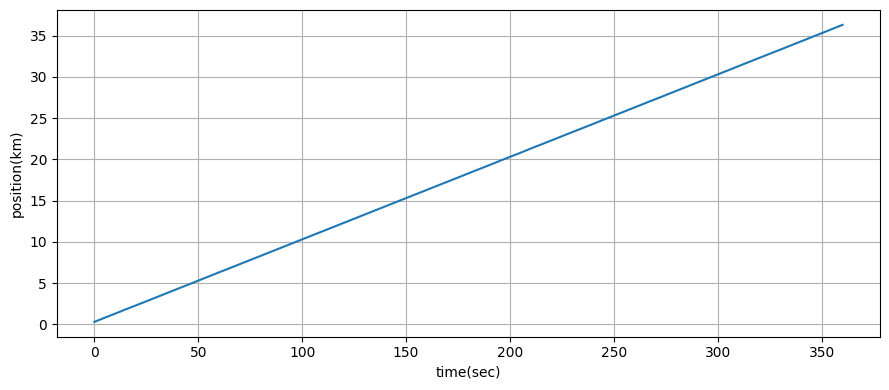

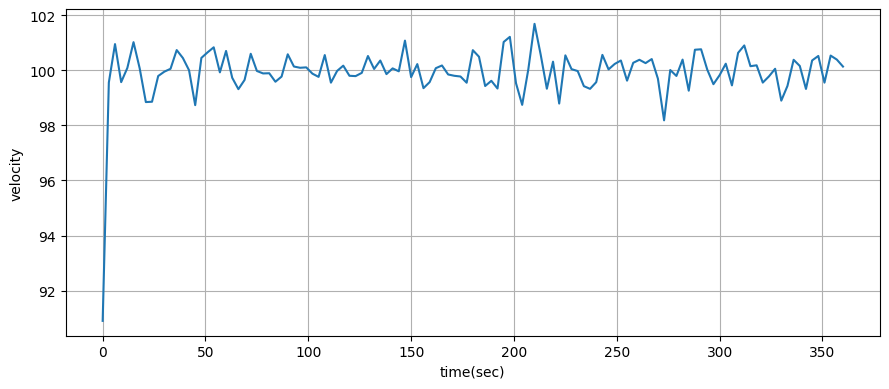

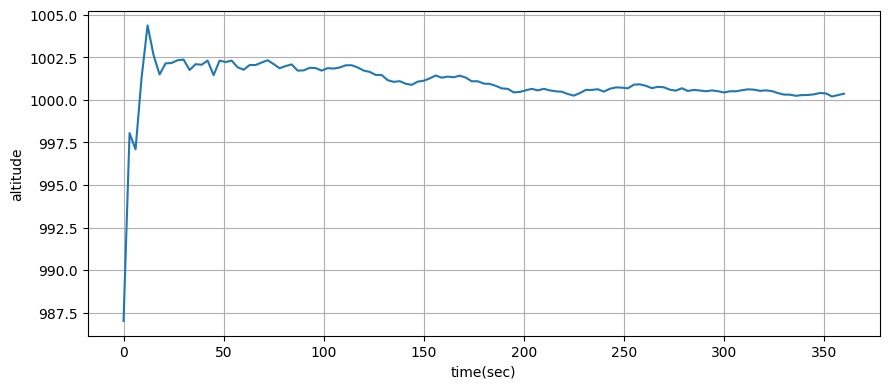

In [22]:
import math
from kf_book.ukf_internal import plot_radar

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, elevation_angle_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)    
plot_radar(xs, time)

这可能会或可能不会给你留下深刻印象，但它给我留下了深刻的印象！ 在扩展卡尔曼滤波器一章中，我们将解决同样的问题，但这需要大量的数学知识。

### Tracking Maneuevering Aircraft

前面的例子产生了很好的结果，但它假设飞机没有改变高度。 以下是飞机在一分钟后开始爬升时的过滤结果。

Actual altitude: 2515.6
UKF altitude   : 1042.1


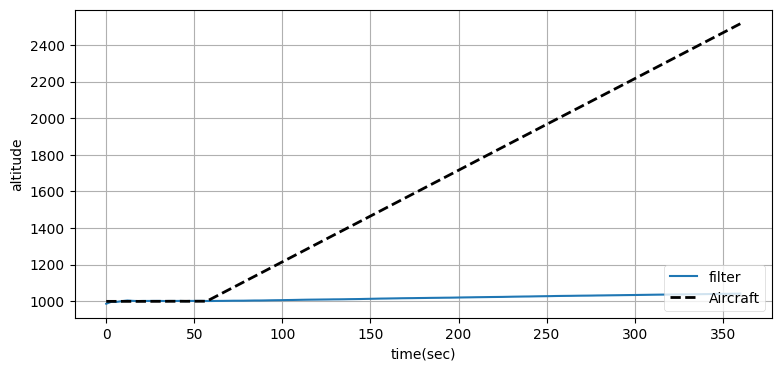

In [23]:
from kf_book.ukf_internal import plot_altitude

# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

过滤器无法跟踪变化的高度。 我们的设计需要改变什么？

我希望您回答“将爬升率添加到状态”，如下所示：


$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude} \\ \mathtt{climb\, rate}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

这需要对状态转换函数进行以下更改，该函数仍然是线性的。

$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&\Delta t \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot x\\ y\\ \dot y\end{bmatrix} 
$$

测量函数保持不变，但我们必须改变 $\mathbf Q$ 以考虑 $\mathbf x$ 的维数变化。

In [24]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft"""
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return F @ x
    
def cv_UKF(fx, hx, R_std):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
    kf = UKF(4, len(R_std), dt, fx=fx, hx=hx, points=points)

    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.R = np.diag(R_std)
    kf.R = kf.R @ kf.R  # square to get variance
    kf.x = np.array([0., 90., 1100., 0.])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

Actual altitude: 2515.6
UKF altitude   : 2500.1


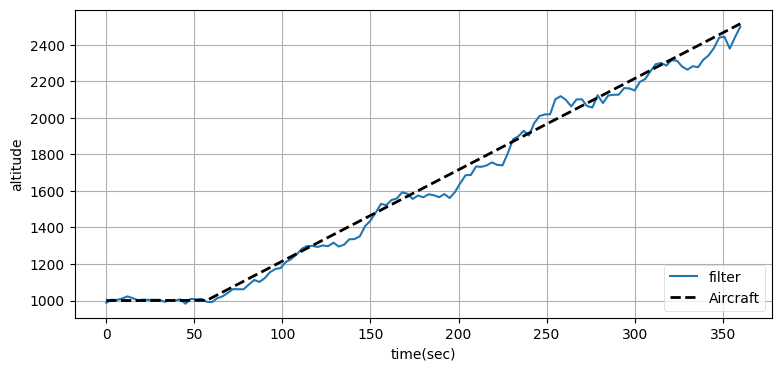

In [25]:
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_cv = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf_cv.predict()
    kf_cv.update([r[0], r[1]]) 
    xs.append(kf_cv.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

高度估计中引入了大量噪声，但我们现在正在准确地跟踪高度。

### Sensor Fusion

现在让我们考虑一个传感器融合的例子。 我们有某种类型的多普勒系统，可以产生 2 m/s RMS 精度的速度估计。 我说“某种类型”是因为与雷达一样，我并不是要教您如何为多普勒系统创建精确的滤波器。 完整的实现必须考虑信噪比、大气效应、系统的几何结构等。

在最后一个示例中，雷达的精度允许我们将速度估计在 1 m/s 左右，我将降低该精度以说明传感器融合的效果。 让我们将距离误差更改为 $\sigma=500$ 米，然后计算估计速度的标准偏差。 我将跳过前几次测量，因为过滤器在此期间会收敛，从而导致人为的大偏差。

不使用多普勒的标准差为：

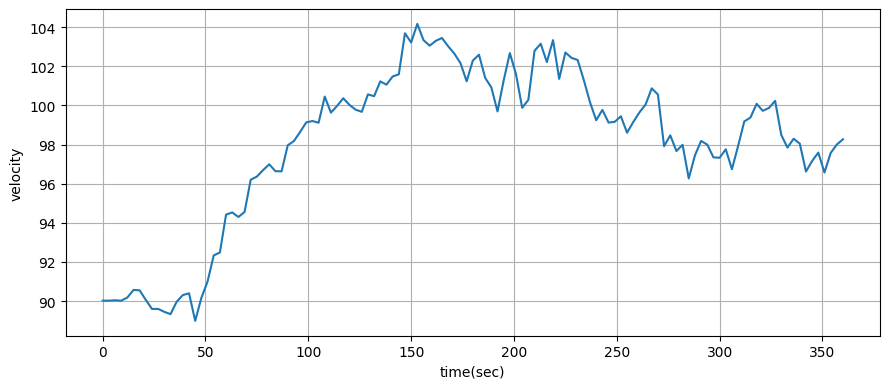

Velocity std 3.4 m/s


In [26]:
range_std = 500.
elevation_angle_std = math.degrees(0.5)
np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_sf = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf_sf.predict()
    kf_sf.update([r[0], r[1]]) 
    xs.append(kf_sf.x)

xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:, 1]):.1f} m/s')

对于多普勒，我们需要将 $x$ 和 $y$ 中的速度包括在测量中。 `ACSim` 类将速度存储在数据成员 `vel` 中。 要执行卡尔曼滤波器更新，我们只需要使用包含 $x$ 和 $y$ 中的倾斜距离、仰角和速度的列表来调用“更新”：

$$z = [\mathtt{slant\_range},\, \text{elevation angle},\, \dot x,\, \dot y]$$

测量包含四个值，因此测量函数也需要返回四个值。 倾斜距离和仰角将像以前一样计算，我们不需要计算 $x$ 和 $y$ 中的速度，因为它们是由状态估计提供的。

In [27]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    elevation_angle = math.atan2(dz, dx)
    return slant_range, elevation_angle, x[1], x[3]

现在我们可以实现我们的过滤器了。

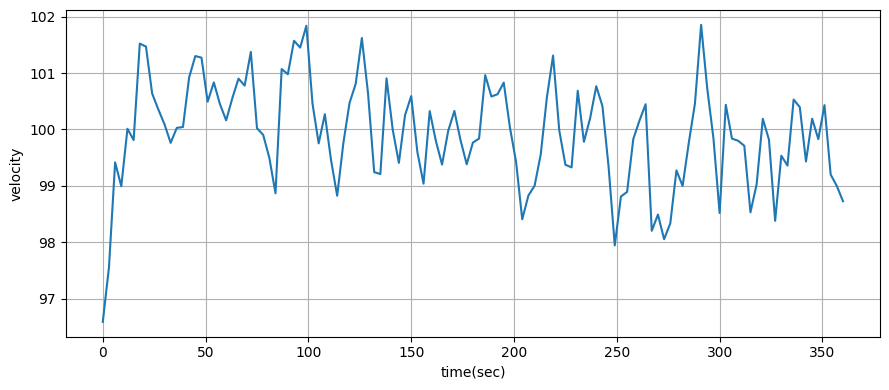

Velocity std 0.9 m/s


In [28]:
h_radar.radar_pos = (0, 0)
h_vel.radar_pos = (0, 0)

range_std = 500.
elevation_angle_std = math.degrees(0.5)
vel_std = 2.

np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)
radar = RadarStation((0, 0), range_std, elevation_angle_std)

kf_sf2 = cv_UKF(f_cv_radar, h_vel, 
            R_std=[range_std, elevation_angle_std, vel_std, vel_std])

time = np.arange(0, 360 + dt, dt)
xs = []
for t in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    # simulate the doppler velocity reading
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf_sf2.predict()
    kf_sf2.update([r[0], r[1], vx, vz]) 
    xs.append(kf_sf2.x)
xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:,1]):.1f} m/s')

通过结合速度传感器，我们能够将标准偏差从 3.5 m/s 降低到 1.3 m/s。

传感器融合是一个很大的话题，这是一个相当简单的实现。 在一个典型的导航问题中，我们有提供*互补*信息的传感器。 例如，GPS 可能每秒提供一次准确的位置更新，但速度估计很差，而惯性系统可能会以 50Hz 提供非常准确的速度更新，但位置估计很糟糕。 每个传感器的优点和缺点是相互正交的。 这导致了*互补滤波器*，它将高更新率的惯性速度测量与准确但缓慢更新的 GPS 位置估计相结合，以产生高速率和准确的位置和速度估计。 高速率速度估计在 GPS 更新之间集成，以产生准确和高速率的位置估计。

### Multiple Position Sensors

最后一个传感器融合问题是一个玩具示例。让我们解决一个不太像玩具的问题。在 GPS 船舶和飞机通过 VOR、LORAN、TACAN、DME 等各种距离和方位系统导航之前。这些系统以无线电波的形式发射信标。传感器从信号中提取信标的范围和/或方位。例如，一架飞机可能有两个 VOR 接收机。飞行员将每个接收机调谐到不同的 VOR 电台。每个 VOR 接收器显示 *radial* - 从地面上的 VOR 站到飞机的方向。飞行员使用图表找到径向线的交点，从而确定飞机的位置。

这是一种精度较低的手动方法。卡尔曼滤波器将产生更准确的位置估计。假设我们有两个传感器，每个传感器都只提供对目标的方位测量，如下图所示。周长的宽度与传感器噪声的 $3\sigma$ 成正比。飞机必须以很高的概率定位在两个周界交叉点内的某个地方。

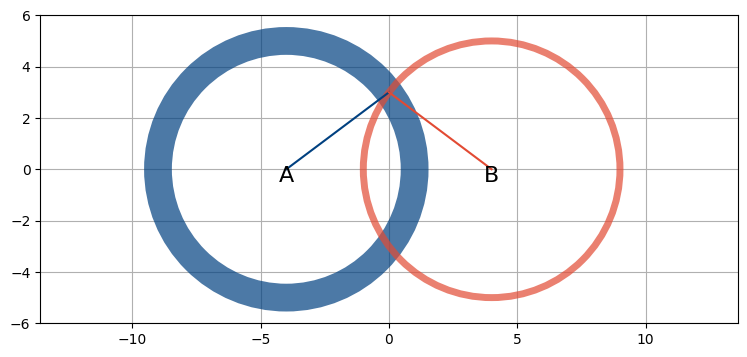

In [29]:
ukf_internal.show_two_sensor_bearing()

我们将传感器和目标之间的方位计算为：

In [30]:
def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])

过滤器以向量的形式接收来自两个传感器的测量值。 该代码将接受任何可迭代的容器，因此我使用 Python 列表来提高效率。 我们可以将其实现为：

In [31]:
def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

假设飞机有一个恒速模型。 为了改变节奏，我明确计算新位置，而不是使用矩阵向量乘法：

In [32]:
def fx_VOR(x, dt):
    x[0] += x[1] * dt
    x[2] += x[3] * dt
    return x

接下来我们实现测量功能。 它将包含测量值的数组的先验转换为两个站点。 我不喜欢全局变量，但我将站点的位置放在全局变量 `sa_pos` 和 `sb_pos` 中来演示这种与 $h()$ 共享数据的方法：

In [33]:
sa_pos = [-400, 0]
sb_pos = [400, 0]

def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)

现在我们编写构建过滤器的样板，运行它并绘制结果：

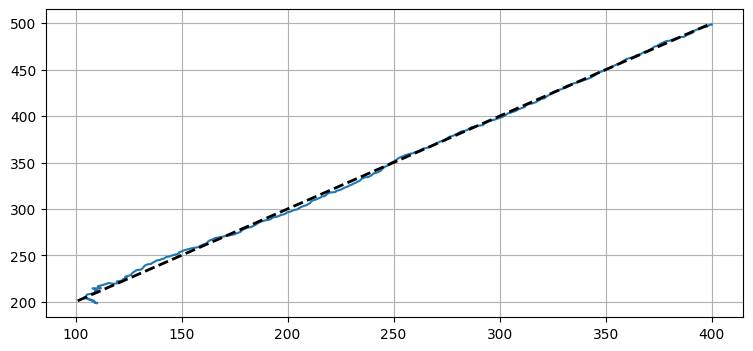

In [34]:
def moving_target_filter(pos, std_noise, Q, dt=0.1, kappa=0.0):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 1000    
    return f

def plot_straight_line_target(f, std_noise):
    xs, txs = [], []
    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[:, 0], txs[:, 1], ls='--', lw=2, c='k')
    plt.show()

np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

这在我看来相当不错。 轨道的开头显示出很大的错误，但过滤器稳定下来并产生了良好的估计。

让我们重新审视角度的非线性。 我将目标定位在两个传感器之间（0,0）。 这将导致残差计算中的非线性，因为平均角度将接近于零。 当角度低于 0 时，测量函数将计算一个接近 $2\pi$ 的大正角度。 因此，预测和测量之间的残差将非常大，接近 $2\pi$ 而不是接近 0。这使得过滤器无法准确执行，如下例所示。

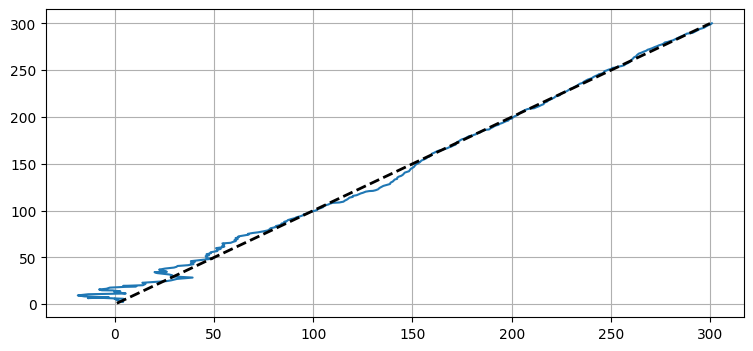

In [35]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

这种表现是不可接受的。 `FilterPy` 的 UKF 代码允许您指定一个函数，该函数在像这样的非线性行为的情况下计算残差。 本章的最后一个例子演示了它的用法。

## Effects of Sensor Error and Geometry

传感器相对于被跟踪物体的几何形状施加了物理限制，在设计滤波器时可能极难处理。 如果 VOR 站的径向几乎彼此平行，那么非常小的角度误差会转化为非常大的距离误差。 更糟糕的是，这种行为是非线性的——*x 轴* 与 *y 轴* 的误差会因实际轴承而异。 这些散点图显示了两个不同轴承的 1°$\sigma$ 误差的误差分布。

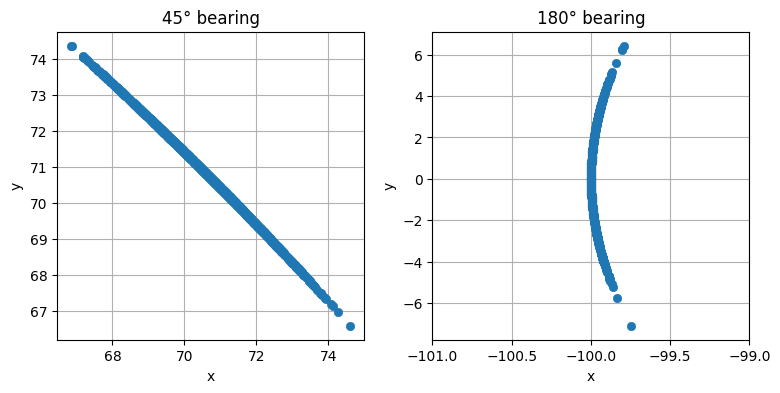

In [36]:
ukf_internal.plot_scatter_of_bearing_error()

## Exercise: Explain Filter Performance

我们可以看到，对于小的角度误差，位置误差非常大。 解释我们如何在上述目标跟踪问题中从 UKF 获得如此好的性能。 回答一个传感器和多个传感器的问题。

### Solution

理解这一点非常重要。 在阅读下面的答案之前，请努力回答这个问题。 如果您不能回答这个问题，您可能需要重新阅读**多维卡尔曼滤波器**一章中的一些早期材料。

有几个因素促成了我们的成功。 首先，让我们考虑只有一个传感器的情况。 任何单一的测量都有一个极端的可能位置范围。 但是，我们的目标正在发生变化，UKF 正在考虑这一点。 让我们绘制连续对移动目标进行的多次测量的结果。

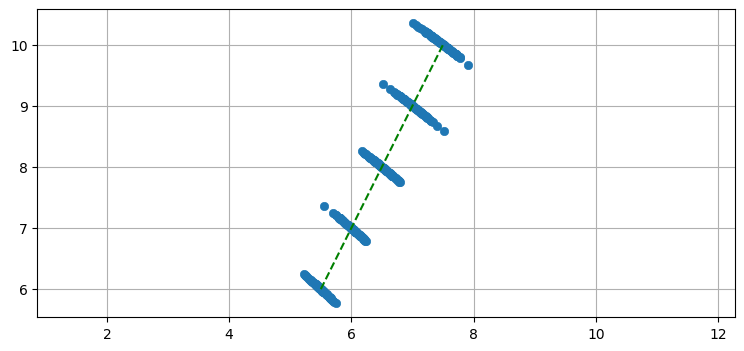

In [37]:
ukf_internal.plot_scatter_moving_target()

每个单独的测量都有非常大的位置误差。然而，连续测量图显示出明显的趋势 - 目标显然正在向右上方移动。当卡尔曼滤波器计算卡尔曼增益时，它通过使用测量函数将误差分布考虑在内。在此示例中，误差位于大约 45° 的线上，因此过滤器将忽略该方向的误差。另一方面，与此正交的测量几乎没有误差，卡尔曼增益再次将其考虑在内。

这个图表看起来很简单，因为我们为每个位置更新绘制了 100 个测量值。飞机的动作很明显。相比之下，卡尔曼滤波器每次更新仅获得一次测量值。因此，过滤器将无法像绿色虚线所暗示的那样产生良好的拟合。

现在考虑方位角没有给我们距离信息。假设我们将初始估计设置为距离传感器 1,000 公里（相对于 7.07 公里的实际距离）并使 $\mathbf P$ 非常小。在该距离处，1° 的误差会转化为 17.5 公里的位置误差。 KF 将永远无法收敛到实际目标位置，因为滤波器对其位置估计非常确定，并且因为在测量中没有提供距离信息。

现在让我们考虑添加第二个传感器的效果。 这里有两个图表显示了不同传感器放置的影响。 我使用正方形和三角形作为两个传感器的符号，并使用相同的符号形状和颜色绘制了由于每个传感器引起的误差分布。 然后我计算了对应于两个噪声方位测量值的 $(x, y)$ 坐标，并用红点绘制它们以显示噪声测量值在 $x$ 和 $y$ 中的分布。

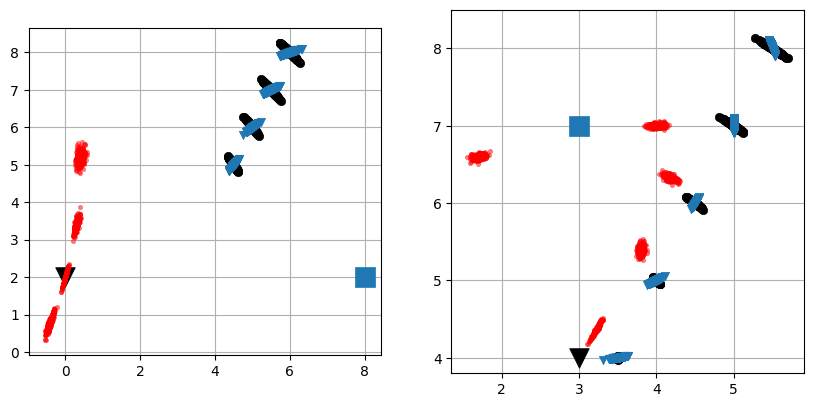

In [38]:
with figsize(10,5):
    ukf_internal.plot_iscts_two_sensors()

在第一个图中，我将传感器放置在与目标的初始位置几乎正交的位置，因此我们得到了这些可爱的“x”形交叉点。 我们可以看到 $x$ 和 $y$ 中的误差如何随着目标按照分散的红点所形成的形状移动而变化——随着目标远离传感器，但靠近传感器 B 的 $y$ 坐标，形状 变成强椭圆。

在第二个图中，飞机开始时非常靠近一个传感器，然后飞过第二个传感器。 误差的交点非常不正交，由此产生的位置误差变得非常分散。

## Implementation of the UKF

FilterPy 实现了 UKF，但学习如何将方程转换为代码具有指导意义。 实施 UKF 非常简单。 首先，让我们编写代码来计算 sigma 点的均值和协方差。

我们将 sigma 点和权重存储在矩阵中，如下所示：

$$ 
\begin{aligned}
\text{weights} &= 
\begin{bmatrix}
w_0& w_1 & \dots & w_{2n}
\end{bmatrix} 
\\
\text{sigmas} &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} & \dots & \mathcal{X}_{0,n-1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \dots & \mathcal{X}_{1,n-1} \\
\vdots & \vdots &  \ddots & \vdots \\
\mathcal{X}_{2n,0} & \mathcal{X}_{2n,1} & \dots & \mathcal{X}_{2n,n-1}
\end{bmatrix}
\end{aligned}
$$


有很多下标来描述一些非常简单的事情，所以这里有一个二维问题（$n$=2）的例子：

In [39]:
points = MerweScaledSigmaPoints(n=2, alpha=.1, beta=2., kappa=1.)
points.sigma_points(x=[0.,0], P=[[1.,.1],[.1, 1]])

array([[ 0.   ,  0.   ],
       [ 0.173,  0.017],
       [ 0.   ,  0.172],
       [-0.173, -0.017],
       [ 0.   , -0.172]])

平均值的 sigma 点位于第一行。 它的位置是 (0, 0)，等于均值 (0,0)。 第二个 sigma 点位于 (0.173, 0.017) 位置，依此类推。 有 $2n+1 = 5$ 行，每个 sigma 点一行。 如果 $n=3$，那么将有 3 列和 7 行。

以行列与列行格式存储 sigma 的选择有些随意。 我的选择使其余代码更清晰，因为我可以将 i$^{th}$ sigma 点称为 `sigmas[i]` 而不是 `sigmas[:, i]`。

### Weights

使用 NumPy 计算权重很容易。 回想一下 Van der Merwe 缩放 sigma 点的实现状态：

$$
\begin{aligned}
\lambda&=\alpha^2(n+\kappa)-n \\ 
W^m_0 &= \frac{\lambda}{n+\lambda} \\
W^c_0 &= \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta \\
W^m_i = W^c_i &= \frac{1}{2(n+\lambda)}\;\;\;i=1..2n
\end{aligned}
$$
    
这些代码是：

```python
lambda_ = alpha**2 * (n + kappa) - n
Wc = np.full(2*n + 1,  1. / (2*(n + lambda_))
Wm = np.full(2*n + 1,  1. / (2*(n + lambda_))
Wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
Wm[0] = lambda_ / (n + lambda_)
```

我在 `lambda_` 中使用下划线，因为 `lambda` 是 Python 中的保留字。 尾随下划线是 Pythonic 解决方法。

### Sigma Points

sigma 点的方程为：

$$
\begin{cases}
\mathcal{X}_0 = \mu \\
\mathcal{X}_i = \mu +  \left[\sqrt{(n+\lambda)\Sigma} \right]_i, & \texttt{for i=1..n} \\
\mathcal{X}_i = \mu - \left[\sqrt{(n+\lambda)\Sigma}\right]_{i-n} & \texttt{for i=(n+1)..2n}
\end{cases}
$$

一旦我们理解了 $\left[\sqrt{(n+\lambda)\Sigma} \right]_i$ 术语，Python 就不难了。

术语 $\sqrt{(n+\lambda)\Sigma}$ 是一个矩阵，因为 $\Sigma$ 是一个矩阵。 $[\sqrt{(n+\lambda)\Sigma}]_i$ 中的下标 $i$ 是选择矩阵的第 i 行向量。 什么是矩阵的平方根？ 没有唯一的定义。 一个定义是矩阵 $\Sigma$ 的平方根是矩阵 $S$，当它与自身相乘时，得到 $\Sigma$：如果 $\Sigma = SS$ 则 $S = \sqrt{\Sigma} 美元。

我们将选择一个具有数值属性的替代定义，使其更易于计算。 我们可以将平方根定义为矩阵 S，当乘以它的转置时，返回 $\Sigma$：

$$
\Sigma = \mathbf{SS}^\mathsf T
$$

这个定义很受欢迎，因为 $\mathbf S$ 是使用 [*Cholesky 分解*](https://en.wikipedia.org/wiki/Cholesky_decomposition) [3] 计算的。 它将 Hermitian 正定矩阵分解为三角矩阵及其共轭转置。 矩阵可以是上
或下三角形，像这样：

$$A=LL^{∗} \\ A=U^{∗}U$$

星号表示共轭转置； 我们只有实数，所以我们可以写：

$$A=LL^\mathsf T \\ A=U^\mathsf T U$$

$\mathbf P$ 具有这些性质，因此我们可以将 $\mathbf S = \text{cholesky}(\mathbf P)$ 视为 $\mathbf P$ 的平方根。

SciPy 在 `scipy.linalg` 中提供了 `cholesky()` 方法。 如果您选择的语言是 Fortran、C 或 C++，诸如 LAPACK 之类的库会提供此例程。 Matlab 提供了`chol()`。

默认情况下，`scipy.linalg.cholesky()` 返回一个上三角矩阵，所以我选择编写代码来期望一个上三角矩阵。 出于这个原因，我逐行访问结果，因此作为中心点的第一个 sigma 点受到整行非零值的影响。 如果您提供自己的平方根实现，则需要考虑到这一点。 您会在文献中找到首先采用值列的 UKF 算法。 如果 cholesky 是下三角形的，或者如果您使用的是不同的算法来计算对称矩阵，那么行与列的顺序无关紧要，这很好。

In [40]:
import scipy
a = np.array([[2., .1], [.1, 3]])
s = scipy.linalg.cholesky(a)
print("cholesky:")
print(s)
print("\nsquare of cholesky:")
print(s @ s.T)

cholesky:
[[1.414 0.071]
 [0.    1.731]]

square of cholesky:
[[2.005 0.122]
 [0.122 2.995]]


因此，我们可以使用以下代码实现 sigma 点：

```python
sigmas = np.zeros((2*n+1, n))
U = scipy.linalg.cholesky((n+lambda_)*P) # sqrt

sigmas[0] = X
for k in range (n):
    sigmas[k+1]   = X + U[k]
    sigmas[n+k+1] = X - U[k]
```

现在让我们实现无味变换。 回想一下方程式

$$\begin{aligned}
\mu &= \sum_i w_i^m\mathcal{X}_i \\
\Sigma &= \sum_i w_i^c{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

我们使用

```python
x = np.dot(Wm, sigmas)
```

如果您不是 NumPy 的重度用户，这对您来说可能看起来很陌生。 NumPy 不仅仅是一个让线性代数成为可能的库； 在后台，它是用 C 和 Fortran 编写的，以实现比 Python 更快的速度。 典型的加速是 20 倍到 100 倍。 为了获得这种加速，我们必须避免使用 for 循环，而是使用 NumPy 的内置函数来执行计算。 因此，我们调用内置的“numpy.dot(x,y)”方法，而不是编写一个 for 循环来计算产品的总和。 两个向量的点积是每个元素的元素乘法之和。 如果传递一个一维数组和一个二维数组，它将计算内积之和：

In [41]:
a = np.array([10, 100])
b = np.array([[1, 2, 3],
              [4, 5, 6]])
np.dot(a, b)

array([410, 520, 630])

剩下的就是计算 $\mathbf P = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf Q$ ：

```python
kmax, n = sigmas.shape
P = zeros((n, n))
for k in range(kmax):
    y = sigmas[k] - x
    P += Wc[k] * np.outer(y, y) 
P += Q
```

这引入了 NumPy 的另一个特性。 状态变量`x`是一维的，`sigmas[k]`也是如此，所以差异`sigmas[k]-X`也是一维的。 NumPy 不会计算一维数组的转置； 它认为 `[1,2,3]` 的转置为 `[1,2,3]`。 所以我们调用函数 `np.outer(y,y)` 计算一维数组 $\mathbf{y}$ 的 $\mathbf{yy}^\mathsf{T}$ 的值。 另一种实现可能是：

```python
y = (sigmas[k] - x).reshape(kmax, 1) # convert into 2D array
P += Wc[K] * np.dot(y, y.T)
```

这段代码比较慢而且不习惯，所以我们不会使用它。

### Predict Step

对于预测步骤，我们将生成上面指定的权重和 sigma 点。 我们通过函数 f 传递每个 sigma 点。

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

然后我们使用 unscented 变换计算预测的均值和协方差。 在下面的代码中，您可以看到我假设这是一个存储过滤器所需的各种矩阵和向量的类中的方法。

```python
def predict(self, sigma_points_fn):
    """ Performs the predict step of the UKF. On return, 
    self.xp and self.Pp contain the predicted state (xp) 
    and covariance (Pp). 'p' stands for prediction.
    """

    # calculate sigma points for given mean and covariance
    sigmas = sigma_points_fn(self.x, self.Pp)

    for i in range(self._num_sigmas):
        self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

    self.xp, self.Pp = unscented_transform(
                       self.sigmas_f, self.Wm, self.Wc, self.Q)
```

### Update Step

更新步骤通过函数“h(x)”将 sigma 转换为测量空间。

$$\mathcal{Z} = h(\mathcal{Y})$$

这些点的均值和协方差是用无味变换计算的。 然后计算残差和卡尔曼增益。 交叉方差计算如下：

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mu)(\boldsymbol{\mathcal Z}_i-\mu_z)^\mathsf T$$

最后，我们使用残差和卡尔曼增益计算新的状态估计：

$$\begin{aligned}
K &= \mathbf P_{xz} \mathbf P_z^{-1}\\
{\mathbf x} &= \mathbf{\bar x} + \mathbf{Ky}
\end{aligned}$$

新的协方差计算为：

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP}_z\mathbf{K}^\mathsf{T}$$

这个函数可以实现如下，假设它是一个存储必要矩阵和数据的类的方法。

```python
def update(self, z):
    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through UT
    zp, Pz = unscented_transform(sigmas_h, self.Wm, self.Wc, self.R)

    # compute cross variance of the state and the measurements
    Pxz = np.zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.Wc[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = np.dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + np.dot(K, z - zp)
    self.P = self.Pp - np.dot(K, Pz).dot(K.T)
```

### FilterPy's Implementation

FilterPy 对代码进行了一些概括。 您可以指定不同的 sigma 点算法，指定如何计算状态变量的残差（您不能减去角度，因为它们是模块化的），提供矩阵平方根函数等等。 有关详细信息，请参阅帮助。

https://filterpy.readthedocs.org/#unscented-kalman-filter

## Batch Processing

卡尔曼滤波器是递归的 - 估计基于当前测量和先前估计。 但是，我们想要过滤一组已经收集的数据是很常见的。 在这种情况下，过滤器可以在 *batch* 模式下运行，其中一次过滤所有测量值。

将测量值收集到数组或列表中。

```python
zs = read_altitude_from_csv()
```

然后调用 `batch_filter()` 方法。

```python
Xs, Ps = ukf.batch_filter(zs)
```

该函数获取测量值列表/数组，对其进行过滤，并返回整个数据集的状态估计 (`Xs`) 和协方差矩阵 (`Ps`) 数组。

这是上面雷达跟踪问题的完整示例。

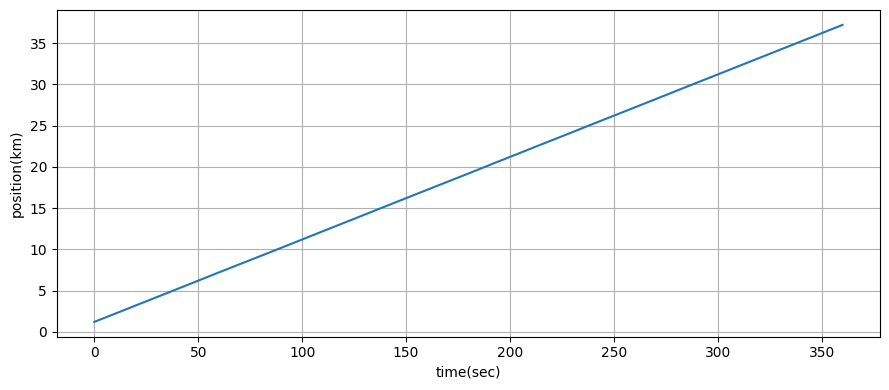

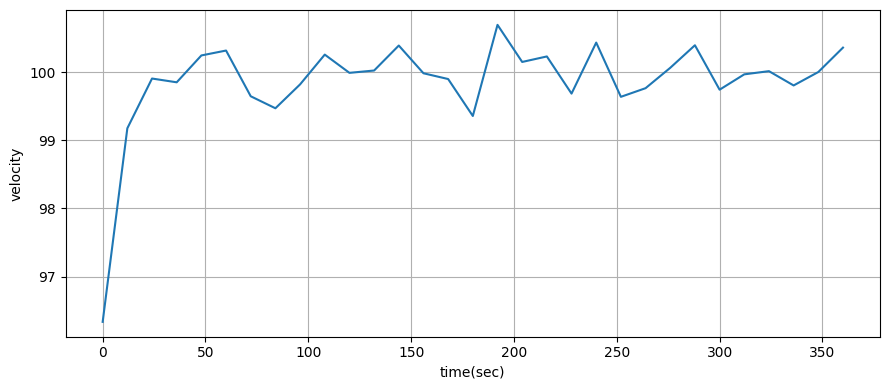

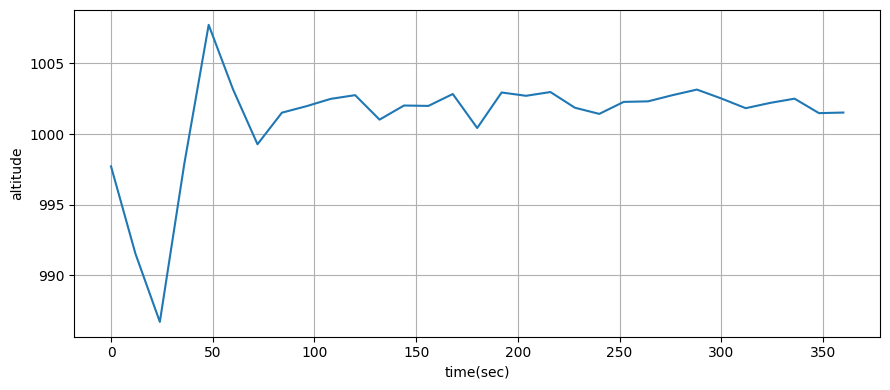

In [42]:
dt = 12. # 12 seconds between readings
range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2 ,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2, 2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

radar = RadarStation((0, 0), range_std, bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

zs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    zs.append([r[0], r[1]])

xs, covs = kf.batch_filter(zs)
ukf_internal.plot_radar(xs, t)

## Smoothing the Results

假设我们正在跟踪一辆车。假设我们得到一个嘈杂的测量结果，表明汽车开始向左转，但状态函数预测汽车正在直线行驶。卡尔曼滤波器别无选择，只能将状态估计稍微移向噪声测量，因为它无法判断这只是一个特别嘈杂的测量还是一个转弯的真正开始。

如果我们正在收集数据并对其进行后处理，我们会在有问题的数据之后进行测量，以告知我们是否进行了转弯。假设随后的测量都继续左转。然后我们可以确定测量不是很嘈杂，而是开始了一个转弯。

我们不会在这里开发数学或算法，我只会告诉你如何在 `FilterPy` 中调用算法。我们实现的算法被称为 *RTS 平滑器*，以算法的三位发明者 Rauch、Tung 和 Striebel 命名。

例程是`UnscentedKalmanFilter.rts_smoother()`。使用它很简单；我们传入从“batch_filter”步骤计算的均值和协方差，并接收平滑后的均值、协方差和卡尔曼增益。

Difference in position in meters:
	 [-1.4166 -0.2815  1.2679 -1.2405 -2.1863]


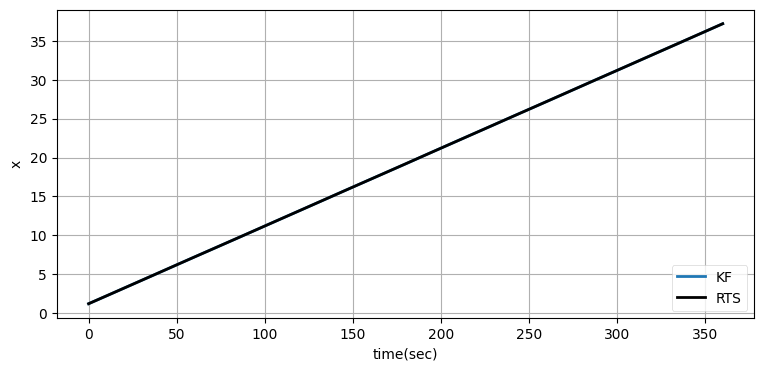

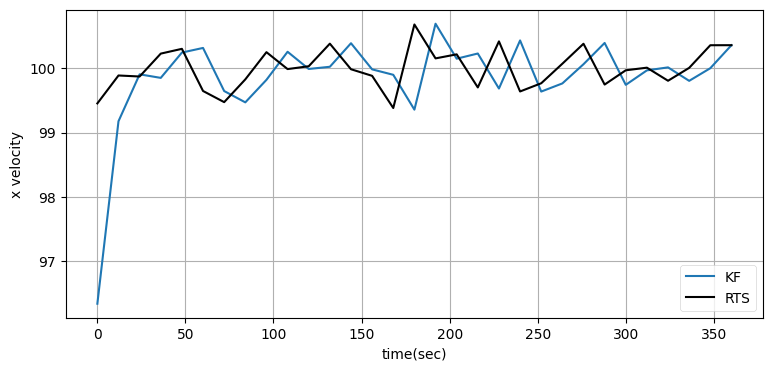

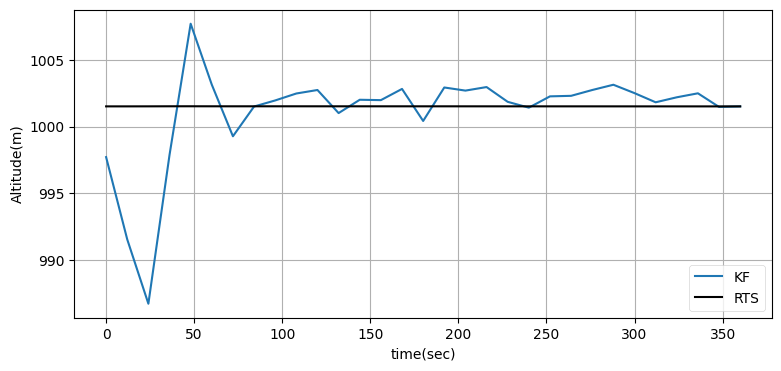

In [43]:
Ms, P, K = kf.rts_smoother(xs, covs)
ukf_internal.plot_rts_output(xs, Ms, t)

从这些图表中我们可以看到，位置的提升很小，但速度的提升还是不错的，而且对于海拔高度来说是惊人的。 位置的差异非常小，所以我打印了最后 5 个点的 UKF 和平滑结果之间的差异。 如果您可以对数据进行后处理，我建议您始终使用 RTS 平滑器。

## Choosing the Sigma Parameters

我发现关于为 $\alpha$、$\beta$ 和 $\kappa$ 选择值的文献相当缺乏。 Van der Merwe 的论文包含的信息最多，但并不详尽。 因此，让我们探索一下他们的工作。

Van der Merwe 建议对高斯问题使用 $\beta=2$，$\kappa=3-n$。 所以让我们从那里开始，改变 $\alpha$。 我会让 $n=1$ 来最小化我们需要查看的数组的大小，并避免计算矩阵的平方根。

In [44]:
from kf_book.ukf_internal import print_sigmas
print_sigmas(mean=0, cov=3, alpha=1)

sigmas:  [ 0.  3. -3.]
mean weights: [0.6667 0.1667 0.1667]
cov weights: [2.6667 0.1667 0.1667]
lambda: 2
sum cov 2.9999999999999996


那么这里发生了什么？ 我们可以看到，对于 0 的平均值，算法选择 0、3 和 -3 的 sigma 点，但为什么呢？ 回忆一下计算 sigma 点的方程：

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

我选择的 $n=1$ 将所有内容都简化为标量，这样我们就可以避免计算矩阵的平方根。 所以，对于我们的价值观，等式是

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= \pm 3
\end{aligned}$$

因此，随着 $\alpha$ 变大，sigma 点变得更加分散。 让我们将其设置为一个荒谬的值。

In [45]:
print_sigmas(mean=0, cov=3, alpha=200)

sigmas:  [   0.  600. -600.]
mean weights: [1. 0. 0.]
cov weights: [-39996.      0.      0.]
lambda: 119999
sum cov -39996.00000000001


我们可以看到 sigma 点分布在 100 个标准差上。如果我们的数据是高斯数据，我们将合并与平均值相差许多标准差的数据；对于非线性问题，这不太可能产生好的结果。但是假设我们的分布不是高斯分布，而是有非常肥大的尾巴？我们可能需要从这些尾部进行采样以获得良好的估计，因此使 $\kappa$ 更大（不是 200，这对于使 sigma 点的变化明显大得离谱）是有意义的。

以类似的推理方式，假设我们的分布几乎没有尾巴——概率分布看起来更像一条倒抛物线。在这种情况下，我们可能希望将 sigma 点拉近均值，以避免在永远不会有真实数据的区域进行采样。

现在让我们看看权重的变化。当我们有 $k+n=3$ 时，平均值的权重为 0.6667，两个外围 sigma 点的权重为 0.1667。另一方面，当 $\alpha=200$ 时，平均权重飙升至 0.99999，异常值权重设置为 0.000004。回忆一下权重方程：

$$\begin{aligned}
W_0 &= \frac{\lambda}{n+\lambda} \\
W_i &= \frac{1}{2(n+\lambda)}
\end{aligned}$$

我们可以看到，随着 $\lambda$ 变大，均值 ($\lambda/(n+\lambda)$) 的权重分数接近 1，其余 sigma 点的权重分数接近 0。 这在协方差的大小上是不变的。 因此，当我们采样越来越远离均值时，我们最终会给这些样本赋予更少的权重，如果我们的采样非常接近均值，我们会给所有样本赋予非常相似的权重。

然而，Van der Merwe 给出的建议是将 $\alpha$ 限制在 $0 \gt \alpha \ge 1$ 范围内。 他建议 $10^{-3}$ 作为一个很好的价值。 让我们试试看。

In [46]:
print_sigmas(mean=0, cov=13, alpha=.001, kappa=0)

sigmas:  [ 0.      0.0036 -0.0036]
mean weights: [-999999.  500000.  500000.]
cov weights: [-999996.  500000.  500000.]
lambda: -0.999999
sum cov 3.9999989999923855


## Robot Localization - A Fully Worked Example

现在是处理重大问题的时候了。大多数书籍都选择简单的教科书式问题和简单的答案，而您却想知道如何解决现实世界的问题。此示例不会教您如何解决任何问题，但会说明您在设计和实现过滤器时必须考虑的事项类型。

我们将考虑机器人定位的问题。在这种情况下，我们有一个机器人正在使用传感器检测地标在景观中移动。这可能是一辆使用计算机视觉识别树木、建筑物和其他地标的自动驾驶汽车。它可能是为您的房子吸尘的小型机器人之一，或者是仓库中的机器人。

该机器人有 4 个轮子，配置与汽车相同。它通过转动前轮进行机动。这导致机器人在向前移动时围绕后轴枢转。这是我们必须建模的非线性行为。

机器人有一个传感器，可以为它提供大致的范围和方位，以了解景观中的已知目标。这是非线性的，因为从范围和方位计算位置需要平方根和三角函数。

过程模型和测量模型都是非线性的。 UKF 兼顾两者，因此我们暂时得出结论，UKF 是解决此问题的可行选择。

### Robot Motion Model

在第一个近似值中，汽车在向前移动的同时通过转动前轮胎来转向。 汽车的前部沿车轮指向的方向移动，同时围绕后轮胎旋转。 这个简单的描述因摩擦而产生的打滑、橡胶轮胎在不同速度下的不同行为以及外侧轮胎需要与内侧轮胎行驶不同的半径等问题而变得复杂。 精确建模转向需要一组复杂的微分方程。

对于卡尔曼滤波，特别是对于低速机器人应用，已发现更简单的*自行车模型*表现良好。 这是模型的描述：

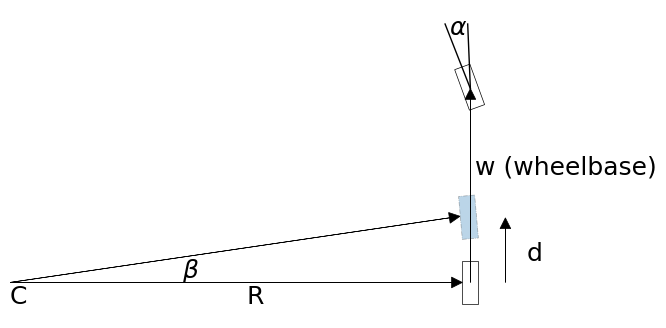

In [47]:
ekf_internal.plot_bicycle()

在这里，我们看到前轮胎相对于轴距指向 $\alpha$ 方向。 在很短的时间内，汽车向前移动，后轮进一步向前并略微向内转动，如蓝色阴影轮胎所示。 在如此短的时间范围内，我们可以将其近似为绕半径 $R$ 的转弯。 我们可以用

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

转弯半径 R 由下式给出

$$R = \frac{d}{\beta}$$

其中，给定前进速度 $v$，后轮行进的距离是 $d=v\Delta t$。

$\theta$ 是机器人的方向，我们计算转弯开始前的位置 $C$

$$\begin{aligned}
C_x &= x - R\sin(\theta) \\
C_y &= y + R\cos(\theta)
\end{aligned}$$

在向前移动时间 $\Delta t$ 后，机器人的新位置和方向为

$$\begin{aligned} \bar x &= C_x + R\sin(\theta + \beta) \\
\bar y &= C_y - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

一旦我们用 $C$ 代替，我们得到

$$\begin{aligned} \bar x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
\bar y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

如果您对转向模型不感兴趣，则无需详细了解此数学。 重要的是要认识到我们的运动模型是非线性的，我们需要用卡尔曼滤波器来处理它。

### Design the State Variables

对于我们的机器人，我们将保持位置和方向：

$$\mathbf x = \begin{bmatrix}x & y & \theta\end{bmatrix}^\mathsf{T}$$

我可以在这个模型中加入速度，但正如你将看到的那样，数学已经非常具有挑战性了。

控制输入 $\mathbf{u}$ 是指令速度和转向角

$$\mathbf{u} = \begin{bmatrix}v & \alpha\end{bmatrix}^\mathsf{T}$$

### Design the System Model

我们将系统建模为非线性运动模型加上白噪声.

$$\bar x = x + f(x, u) + \mathcal{N}(0, Q)$$

使用我们上面创建的机器人运动模型，我们可以编写：

In [48]:
from math import tan, sin, cos, sqrt

def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb, 
                              r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

我将设计 UKF 以使 $\Delta t$ 很小。 如果机器人移动缓慢，那么这个函数应该给出一个相当准确的预测。 如果 $\Delta t$ 很大或者您的系统动力学非常非线性，则此方法将失败。 在这些情况下，您将需要使用更复杂的数值积分技术（例如 Runge Kutta）来实现它。 **卡尔曼滤波器数学**一章简要介绍了数值积分。

### Design the Measurement Model

该传感器为景观中的多个已知位置提供嘈杂的方位和范围。 测量模型必须将状态 $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$ 转换为范围和与地标的方位。 如果 $p$ 是地标的位置，则范围 $r$ 是

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

我们假设传感器提供相对于机器人方位的方位，因此我们必须从方位中减去机器人的方位以获取传感器读数，如下所示：

$$\phi = \tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$$

因此我们的测量函数是

$$\begin{aligned}
\mathbf{z}& = h(\mathbf x, \mathbf P) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

我不会实现这个，因为有一个困难将在下面的*实现*部分中讨论。

### Design Measurement Noise

可以合理地假设范围和轴承测量噪声是独立的，因此

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

在我们开始编码之前，我们还有另一个问题需要处理。 残差是 $y = z - h(x)$。 假设 z 的方位角为 $1^\circ$，$h(x)$ 为 $359^\circ$。 减去它们得到 $-358^\circ$。 这将抛出卡尔曼增益的计算，因为正确的角度差是 $2^\circ$。 所以我们必须编写代码来正确计算方位残差。

In [49]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [ ]:
print(np.degrees(normalize_angle(np.radians(1-359))))

状态向量在索引 2 处有方位，但测量向量在索引 1 处有方位，因此我们需要编写函数来处理每个方位。 我们面临的另一个问题是，当机器人操纵不同的地标时，将会看到不同的地标，因此我们需要处理可变数量的测量。 测量中的残差函数将传递一个包含多个测量值的数组，每个地标一个。

In [50]:
def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

我们现在可以实现测量模型。 方程是

$$h(\mathbf x, \mathbf P)
= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix}$$

表达式 $\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$ 可以产生超出 $[-\pi, \pi)$ 范围的结果，所以我们应该规范化 该范围的角度。

该函数将传递一个地标数组，并且需要以“[dist_to_1，bearing_to_1，dist_to_2，bearing_to_2，...]”的形式生成一个测量数组。

In [51]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

我们的困难还没有结束。 unscented 变换计算状态向量和测量向量的平均值，但每个向量都包含一个方位。 没有唯一的方法来计算一组角度的平均值。 例如，359$^\circ$ 和 3$^\circ$ 的平均值是多少？ 直觉认为答案应该是 1$^\circ$，但一个简单的 $\frac{1}{n}\sum x$ 方法会产生 181$^\circ$。

一种常见的方法是取正弦和余弦之和的反正切。

$$\bar{\theta} = atan2\left(\frac{\sum_{i=1}^n \sin\theta_i}{n}, \frac{\sum_{i=1}^n \cos\theta_i}{n}\right)$$

`UnscentedKalmanFilter.__init__()` 有一个参数 `x_mean_fn` 用于计算状态平均值的函数，以及 `z_mean_fn` 用于计算测量平均值的函数。 我们将这些函数编码为：

In [52]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = atan2(sum_sin, sum_cos)
    return x

这些函数利用了 NumPy 的三角函数对数组进行操作的事实，并且 `dot` 执行逐元素乘法。 NumPy 是用 C 和 Fortran 实现的，因此 `sum(dot(sin(x), w))` 比用 Python 编写等效循环要快得多。

完成后，我们现在准备实施 UKF。我想指出，当我设计这个过滤器时，我并不仅仅是从头开始设计上面的所有功能。我将一个基本的 UKF 与预定义的地标放在一起，验证它是否有效，然后开始填充。 “如果我看到不同的地标怎么办？”这导致我更改测量功能以接受一系列地标。 “我如何处理计算角度的残差？”这导致我编写了角度归一化代码。 “一组角度的*均值*是多少？”我在互联网上搜索，在 Wikipedia 上找到了一篇文章，并实现了该算法。不要害怕。设计你能做的，然后提出问题并一一解决。

您已经看过 UKF 的实现，所以我不会详细描述它。这里有两个新东西。当我们构造 sigma 点和过滤器时，我们必须为其提供我们编写的函数来计算残差和均值。

```python
points = SigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                     subtract=residual_x)

ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=Hx, dt=dt, points=points,
         x_mean_fn=state_mean, z_mean_fn=z_mean,
         residual_x=residual_x, residual_z=residual_h)
```

接下来，我们需要将额外的数据传递给我们的 `f(x, dt)` 和 `h(x)` 函数。 我们想对 f(x, dt) 使用 move(x, dt, u, 轴距)，对 h(x) 使用 Hx(x, landmarks)。 我们可以这样做，我们只需将额外的参数作为关键字参数传递给`predict()`和`update()`，就像这样：

```python
            ukf.predict(u=u, wheelbase=wheelbase)        
            ukf.update(z, landmarks=landmarks)
```

其余代码运行模拟并绘制结果。 我创建了一个包含地标坐标的变量“地标”。 我每秒更新模拟机器人位置 10 次，但每秒只运行一次 UKF。 我们没有使用 Runge Kutta 来积分运动的微分方程，因此较小的时间步长会使模拟更加准确。

In [53]:
from filterpy.stats import plot_covariance_ellipse

dt = 1.0
wheelbase = 0.5

def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, ellipse_step=1, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UKF(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='k', alpha=0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

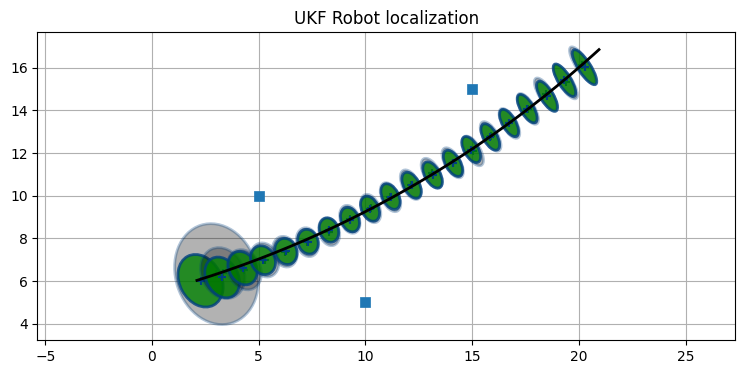

Final P: [0.0092 0.0187 0.0007]


In [54]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())

其余代码运行模拟并绘制结果。 我创建了一个包含地标坐标的变量“地标”。 我每秒更新模拟机器人位置 10 次，但只运行一次 UKF。 这有两个原因。 首先，我们没有使用 Runge Kutta 来积分运动的微分方程，因此较窄的时间步长可以让我们的模拟更加准确。 其次，在嵌入式系统中处理速度有限是很正常的。 这迫使您仅在绝对需要时才运行卡尔曼滤波器。

### Steering the Robot

上面运行的转向模拟是不现实的。 速度和转向角从未改变，这对卡尔曼滤波器没有太大问题。 我们可以实现复杂的 PID 控制机器人模拟，但我将使用 NumPy 的 `linspace` 方法生成不同的转向命令。 我还将添加更多的地标，因为机器人将比第一个示例走得更远。

In [55]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
  return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)

不确定性很快变得非常小。 协方差椭圆显示 $6\sigma$ 协方差，但椭圆非常小，很难看到。 我们可以通过仅在起点附近提供两个地标来将更多错误纳入答案。 当我们运行这个过滤器时，错误会随着机器人远离这些地标而增加。

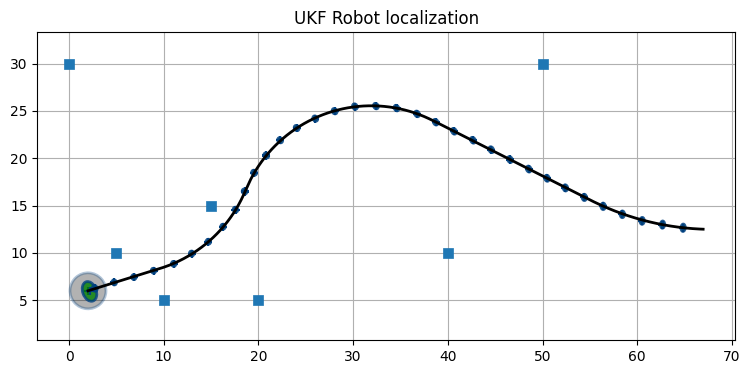

final covariance [0.0013 0.0043 0.0004]


In [56]:
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

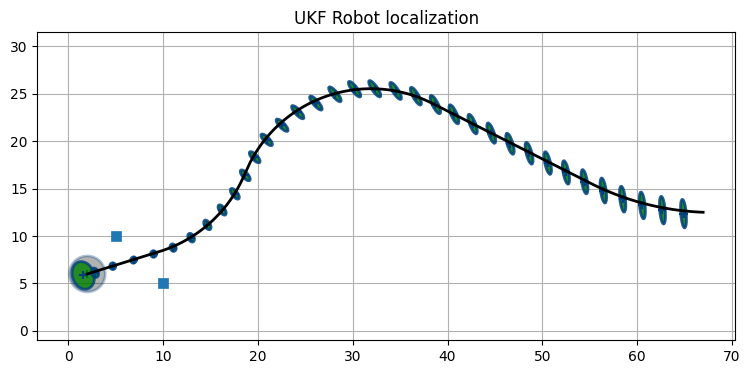

final covariance [0.0026 0.0657 0.0008]


In [57]:
ukf = run_localization(
    cmds, landmarks[0:2], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

## Discussion

您对本章的印象可能取决于您过去实现了多少非线性卡尔曼滤波器。如果这是您第一次接触，那么 $2n+1$ sigma 点的计算以及随后编写的 $f(x)$ 和 $h(x)$ 函数可能会让您觉得有点挑剔。事实上，由于需要处理角度的模块化数学，我花费的时间比我愿意承认的要让一切正常工作更多。另一方面，如果您实施了扩展卡尔曼滤波器 (EKF)，也许您会在座位上兴高采烈地弹跳。为 UKF 编写函数会有些乏味，但概念非常基础。同一问题的 EKF 需要一些相当困难的数学。对于许多问题，我们无法找到 EKF 方程组的封闭形式解，我们必须退回到某种迭代解。

UKF 相对于 EKF 的优势不仅在于相对容易实施。讨论这个有点为时过早，因为您还没有学习 EKF，但是 EKF 在某一点线性化问题并将该点通过线性卡尔曼滤波器。相比之下，UKF 需要 $2n+1$ 个样本。因此，UKF 通常比 EKF 更准确，尤其是当问题高度非线性时。虽然不能保证 UKF 总是优于 EKF，但实际上它已被证明至少表现得一样好，而且通常比 EKF 好得多。

因此，我的建议是始终从实施 UKF 开始。如果您的过滤器出现分歧（人员死亡、大量资金损失、发电厂爆炸）时会产生现实后果，那么您当然必须进行复杂的分析和实验才能选择最佳过滤器。这超出了本书的范围，你应该去研究生院学习这个理论。

最后，我将 UKF 称为执行 sigma 点过滤器的*方法。这不是真的。我选择的具体版本是 Julier 的缩放无味过滤器，由 Van der Merwe 在他 2004 年的论文中参数化。如果您搜索 Julier、Van der Merwe、Uhlmann 和 Wan，您会发现他们开发的一系列类似的 sigma 点滤波器。每种技术都使用不同的方式来选择和加权 sigma 点。但选择并不止于此。例如，SVD 卡尔曼滤波器使用奇异值分解 (SVD) 来找到概率分布的近似均值和协方差。将本章视为对 sigma 点滤波器的介绍，而不是对它们如何工作的明确处理。

## References

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [1] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [2] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [3] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition